In [3]:
import numpy as np
import pandas as pd
import gensim
from IPython.display import Image
###################################
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer
import nltk

## Function Defination

In [4]:
import numpy as np
import pandas as pd
import re

def data_cleaning3(all_data,removeNa = True, keep_percent = False, rmPunctuation = True, rmNums = True, rmStopWords = True):
	
	all_data['alltext'] = all_data['alltext'].apply(lambda x: x.lower())
	
	if removeNa:
		all_data = all_data[all_data['alltext'].isnull() == False]


	if keep_percent:
		def replace_perc(str_perc):
			str_perc02 = re.sub('(\d+\%)\s*([a-z]+)','\\2\\1 \\2,', str_perc)
			return re.sub('([a-z]+)\s+(\d+\%)', '\\1\\2 \\1,', str_perc)

		all_data['alltext'] = all_data['alltext'].apply(replace_perc)

	if rmPunctuation:
		puncList = '!"#$&%\'()*+-,./:;<=>?@[\\]^_`{|}~'
		def rm_punc(s):
			s = re.sub('([a-z]+)\-([a-z]+)', '\\1\\2', s)
			for x in puncList:
				s=s.replace(x,' ')
			return s

		all_data['alltext'] = all_data['alltext'].apply(rm_punc)

	if rmNums:
		def rm_nums(s):
	#		s = re.sub('\s+\d+\s+', '', s)
			s = re.sub('\d+', '', s)
			return s

		all_data['alltext'] = all_data['alltext'].apply(rm_nums)

	if rmStopWords:
		def rm_stop(s):
			stop = ['ASOS', "YAS", "Ditsy", "Noisy", "May", "Ted","Baker", "River","Island", "Karen","Scott","PrettyLittleThing","Roxy","DESIGN","Chi", \
               "Alfani","Boohoo","Sofie","Schnoor","Ellesse", "Jeannie","TFNC","Sacred", "Hawk","Urban","Bliss","Puma","adidas", "Stella", \
               'cm', 'size', 'web id', 'approx', 'model', 'height', 'is', 'and', 'she', 'wearing', 'small', 'approximate', 'measurements', 'height', 'bust', 'waist', 'hips']
			
			lst = r'|'.join([x.lower() for x in stop])
			
			return re.sub(lst,'',s)

		all_data['alltext'] = all_data['alltext'].apply(rm_stop)


	return all_data

<input>:15: DeprecationWarning: invalid escape sequence \d
<input>:15: DeprecationWarning: invalid escape sequence \d
<input>:15: DeprecationWarning: invalid escape sequence \d
<input>:15: DeprecationWarning: invalid escape sequence \d
<input>:16: DeprecationWarning: invalid escape sequence \s
<input>:15: DeprecationWarning: invalid escape sequence \d
<input>:16: DeprecationWarning: invalid escape sequence \s
<input>:15: DeprecationWarning: invalid escape sequence \d
<input>:16: DeprecationWarning: invalid escape sequence \s
<input>:15: DeprecationWarning: invalid escape sequence \d
<input>:16: DeprecationWarning: invalid escape sequence \s
<input>:15: DeprecationWarning: invalid escape sequence \d
<input>:16: DeprecationWarning: invalid escape sequence \s
<input>:15: DeprecationWarning: invalid escape sequence \d
<input>:16: DeprecationWarning: invalid escape sequence \s
<input>:15: DeprecationWarning: invalid escape sequence \d
<input>:16: DeprecationWarning: invalid escape sequence 

In [34]:
lemtzer = WordNetLemmatizer()

def lemmatize_stemming(text):
    return lemtzer.lemmatize(text, pos='v')

# Write a function to perform the pre processing steps on the entire dataset
def preprocess(text):
    result=[]
    for token in simple_preprocess(text) :
        if token not in STOPWORDS and len(token) > 3:
            result.append(lemmatize_stemming(token))
            
    return result

# Train the model. There are two output, the first one is the trained model, the second one is the input dictionary
def trainLDA(df, count = 10, num_topics = 5, alpha = 0.1, passes=2, iterations=50, filter_dict = False, no_below=10, no_above=0.1):
    processed_docs  = []
    for doc in df['alltext']:
        processed_docs.append(preprocess(doc))
        
    dictionary = gensim.corpora.Dictionary(processed_docs)
    
    if filter_dict:
        dictionary.filter_extremes(no_below=no_below, no_above=no_above, keep_n=100000)
    
    bow_corpus = [dictionary.doc2bow(doc) for doc in processed_docs]
    
    lda_model = gensim.models.LdaMulticore(bow_corpus, num_topics=num_topics, id2word=dictionary, alpha = alpha, passes=passes, iterations=iterations)
    lda_model.save('lda_{}.model'.format(count))
    
    for idx, topic in lda_model.print_topics(-1):
        print('Topic: {} Word: {}\n'.format(idx, topic))
    
    return lda_model, dictionary, bow_corpus
    

# process the input data for model training.     
def inputPrep(df, filter_dict = False):
    processed_docs  = []
    for doc in df['alltext']:
        processed_docs.append(preprocess(doc))
        
    dictionary = gensim.corpora.Dictionary(processed_docs)
    if filter_dict:
        dictionary.filter_extremes(no_below=10, no_above=0.1, keep_n=100000)    
    
    bow_corpus = [dictionary.doc2bow(doc) for doc in processed_docs]
    
    return dictionary, bow_corpus

# Print out the pictures of each catergory
def groupPic(df, model, dictionary):
    result_dic = {}
    for i in df['id']:
        bow_vector = dictionary.doc2bow(preprocess(df[df['id'] == i]['alltext'].tolist()[0]))
        highest_score = sorted(model[bow_vector], key = lambda tup:tup[1])[-1]
        groupID = highest_score[0]
        print(highest_score)
        if groupID in result_dic.keys():
            result_dic[groupID].append(i)
        else:
            result_dic[groupID] = [i]
    
    print('The groups are:')
    print(result_dic)
    print('#'* 50)

    for key in result_dic.keys():
        print('#'*50)
        print('group number : {}'.format(key))
        print('#'*50)
        
        for i in result_dic[key]:
            file_name = './product_images/{}.jpg'.format(i)
            display(Image(filename = file_name, width=200, height=200))
            print('######### {}.jpg ###########'.format(i))

## Load Input Data

In [11]:
df_all = pd.read_csv('all.csv', index_col = 0)

## Simple Clean-up

In [12]:
df_all3 = data_cleaning3(df_all,removeNa = True, keep_percent = False, rmPunctuation = True, rmNums = True, rmStopWords = True)

In [13]:
df_all3.shape

(10610, 12)

## LDA Modeling

### You guys can play around with the number of topics, alpha, passes and iteration number

In [14]:
%%time
lda_md3, dict3_, corpus3_ = trainLDA(df_all3, count = 2, num_topics = 6, alpha = 0.1, passes=100, iterations=500, filter_dict = True)

Topic: 0 Word: 0.028*"washable" + 0.023*"hit" + 0.020*"crea" + 0.019*"macy" + 0.018*"silhouette" + 0.017*"unlined" + 0.016*"size" + 0.016*"seam" + 0.013*"zipper" + 0.012*"cuff"

Topic: 1 Word: 0.039*"order" + 0.035*"normal" + 0.026*"clean" + 0.026*"btag" + 0.026*"wash" + 0.025*"return" + 0.022*"item" + 0.021*"base" + 0.021*"exclusive" + 0.020*"attach"

Topic: 2 Word: 0.031*"plain" + 0.028*"crop" + 0.026*"rib" + 0.025*"things" + 0.023*"complicate" + 0.020*"maternity" + 0.017*"wardrobe" + 0.017*"organic" + 0.017*"bump" + 0.016*"baby"

Topic: 3 Word: 0.058*"lace" + 0.022*"available" + 0.020*"black" + 0.018*"mesh" + 0.018*"rayon" + 0.018*"embroider" + 0.017*"plea" + 0.015*"maxi" + 0.014*"nylon" + 0.014*"sequin"

Topic: 4 Word: 0.027*"relax" + 0.026*"overd" + 0.025*"logo" + 0.023*"comfort" + 0.022*"collar" + 0.022*"placket" + 0.021*"shirt" + 0.017*"drop" + 0.016*"pocket" + 0.015*"sweatshirt"

Topic: 5 Word: 0.037*"wrap" + 0.024*"ruffle" + 0.024*"drape" + 0.021*"midi" + 0.020*"softly" + 0.01

In [28]:
corpus3_

[[(0, 1), (1, 1)],
 [(2, 1), (3, 1)],
 [(4, 1), (5, 2), (6, 1), (7, 1), (8, 1), (9, 1)],
 [(0, 1), (1, 1), (2, 1), (10, 1), (11, 1), (12, 1), (13, 1)],
 [(14, 2), (15, 1)],
 [(8, 1), (16, 1)],
 [(17, 1), (18, 1)],
 [(8, 1)],
 [(8, 1)],
 [(8, 1), (12, 1), (13, 1), (14, 2), (15, 1), (19, 1), (20, 1)],
 [],
 [(8, 1)],
 [(15, 1), (21, 1)],
 [(8, 1)],
 [(0, 1), (1, 1)],
 [(22, 2)],
 [(7, 1), (23, 1), (24, 2)],
 [(25, 1), (26, 1), (27, 1)],
 [(7, 1), (28, 1), (29, 1), (30, 1), (31, 1)],
 [(23, 1), (30, 2), (32, 2)],
 [(8, 1), (17, 1), (18, 1), (33, 1), (34, 1), (35, 1), (36, 1), (37, 1)],
 [(1, 1), (6, 1), (38, 1), (39, 1), (40, 1)],
 [(8, 1), (28, 1), (31, 1), (41, 1), (42, 1), (43, 1)],
 [(8, 1),
  (12, 1),
  (13, 1),
  (23, 1),
  (32, 2),
  (44, 1),
  (45, 1),
  (46, 1),
  (47, 2)],
 [(2, 1), (12, 1), (21, 1), (39, 1), (41, 1), (48, 1), (49, 1), (50, 2)],
 [(4, 1), (8, 1), (16, 1), (22, 1), (23, 1), (30, 1), (51, 2)],
 [(5, 1), (7, 2), (52, 1)],
 [(5, 2), (14, 1), (15, 1), (23, 1), (30, 1

In [29]:
df_all3['alltext']

0        cotton tshirt tshirt in lightweight cotton jer...
1        vneck jersey top longsleeved top in airy vcose...
2        jersey top with lace sleeveless top in soft vc...
3        vneck top conscious  vneck top in airy jersey ...
4        jersey camole top fit camole top in jersey wit...
5        short tshirt short tshirt in soft jersey with ...
6        long tshirt long tshirt in jersey with sewn cu...
7                    tshirt fit tshirt in soft jersey  fit
8        tshirt tshirt in soft  vcoseblend jersey  cott...
9        vneck camole top vneck camole top in soft vcos...
10       vneck jersey top short  fit top in cotton jers...
11                   tshirt fit tshirt in soft jersey  fit
12       vneck top top in woven fabric with vneck front...
13       tshirt tshirt in soft  vcoseblend jersey  cott...
14       cotton tshirt tshirt in lightweight cotton jer...
15       tshirt with motif tshirt in jersey with a moti...
16       oneshoulder top sleeveless  fit oneshoulder to.

## Show Pictures

### Just try to put some random sampling of the data. DO NOT PUT ALL DATA IN !!!!!!

### You need to have the picture folders in the same directory. (./product_images/)

(0, 0.9342058)
(5, 0.92423)
(4, 0.6602546)
(2, 0.960315)
(4, 0.8959895)
(5, 0.38520876)
(4, 0.7312828)
(5, 0.9528282)
(5, 0.9568919)
(3, 0.9757261)
(3, 0.57019985)
(4, 0.96794575)
(0, 0.97158754)
(5, 0.5877221)
(2, 0.524064)
(0, 0.794468)
(0, 0.9342057)
(2, 0.5535721)
(1, 0.6618015)
(0, 0.98119915)
(2, 0.67097914)
(4, 0.9715899)
(5, 0.8612043)
(4, 0.9479107)
(3, 0.7688258)
(5, 0.49205694)
(2, 0.55392057)
(4, 0.55488837)
(4, 0.8912914)
(4, 0.96987146)
(3, 0.9657515)
(0, 0.9418559)
(1, 0.96987593)
(4, 0.52138335)
(2, 0.62351596)
(4, 0.9568827)
(0, 0.61288154)
(2, 0.78981215)
(1, 0.61061454)
(0, 0.9479102)
(3, 0.62171966)
(5, 0.52865565)
(0, 0.44477615)
(0, 0.6874536)
(4, 0.79481524)
(0, 0.9342005)
(3, 0.9603161)
(2, 0.71672696)
(4, 0.64216524)
(4, 0.83406186)
The groups are:
{0: [608, 1496, 2106, 701, 2147, 342, 855, 1097, 747, 13, 785], 5: [8626, 8720, 7777, 10190, 4485, 8558, 4227, 5414], 4: [9906, 7434, 5011, 4051, 4014, 4924, 8924, 5583, 6031, 6663, 3906, 5957, 3995, 5071], 2: [6250,

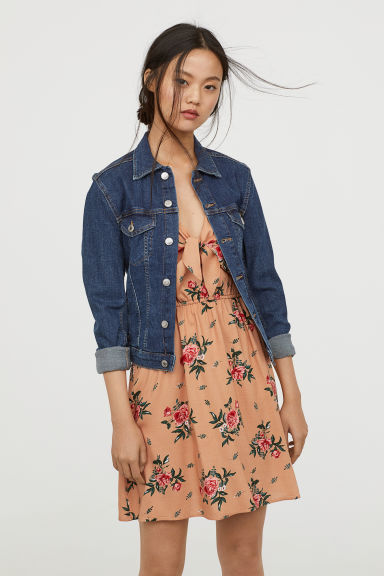

######### 608.jpg ###########


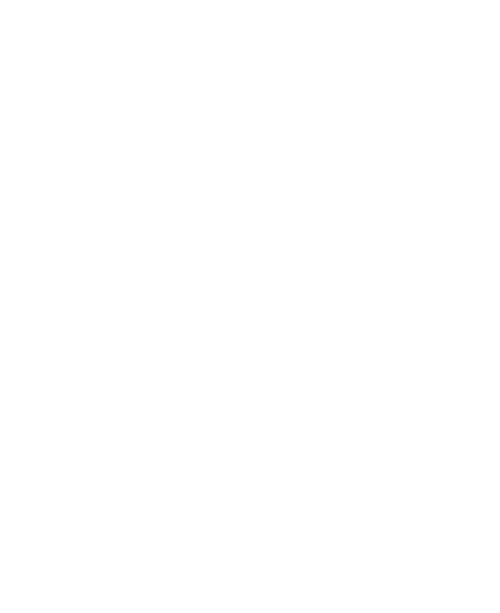

######### 1496.jpg ###########


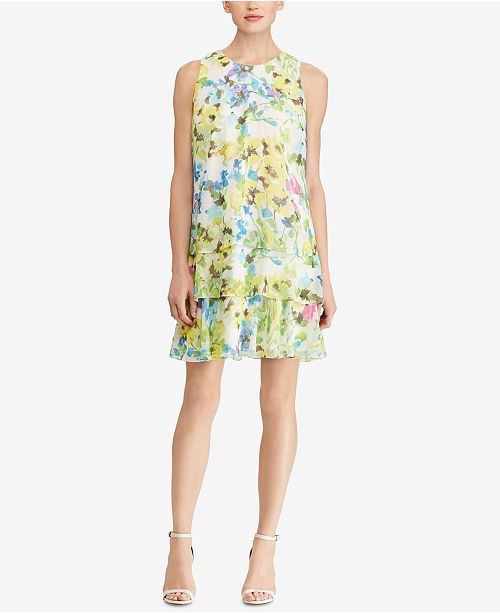

######### 2106.jpg ###########


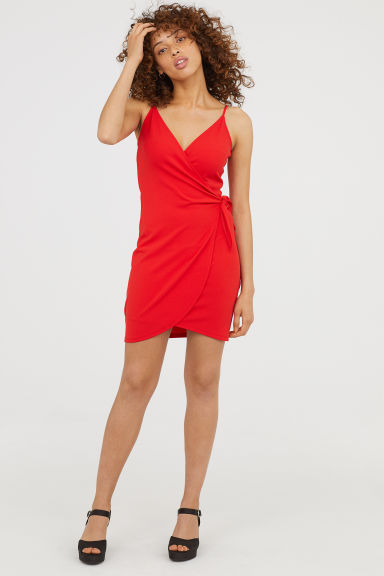

######### 701.jpg ###########


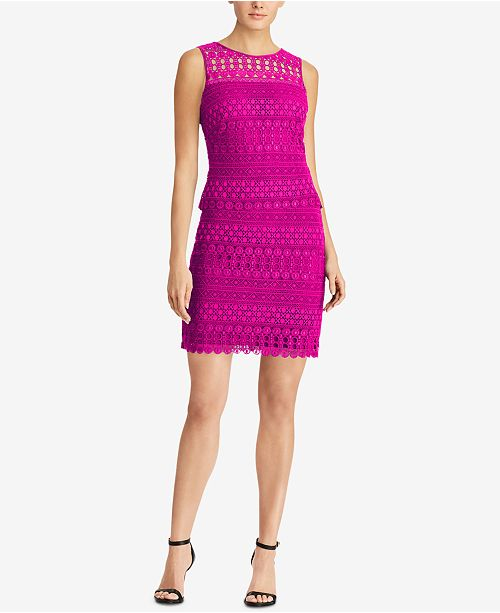

######### 2147.jpg ###########


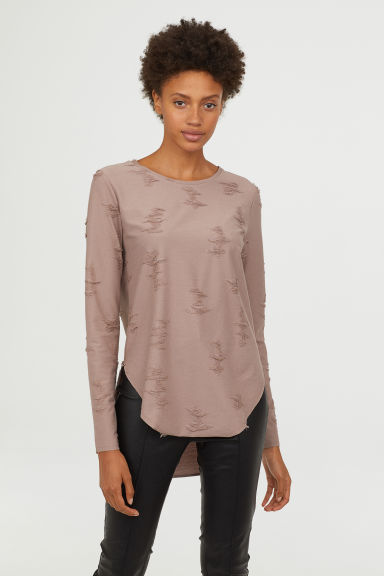

######### 342.jpg ###########


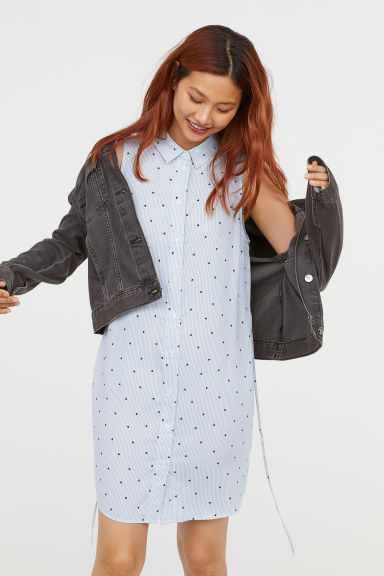

######### 855.jpg ###########


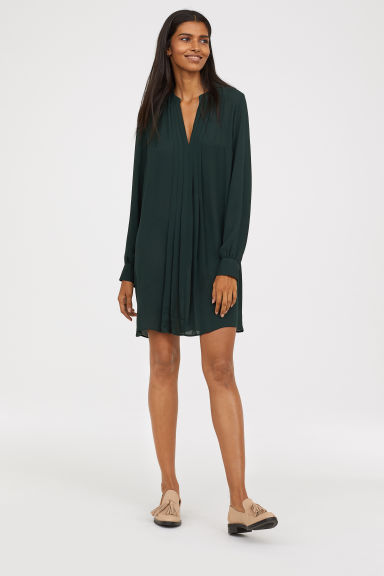

######### 1097.jpg ###########


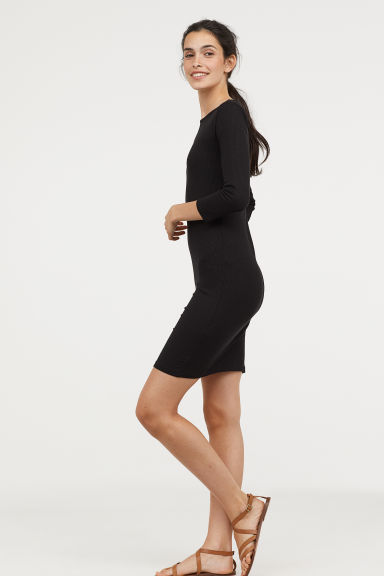

######### 747.jpg ###########


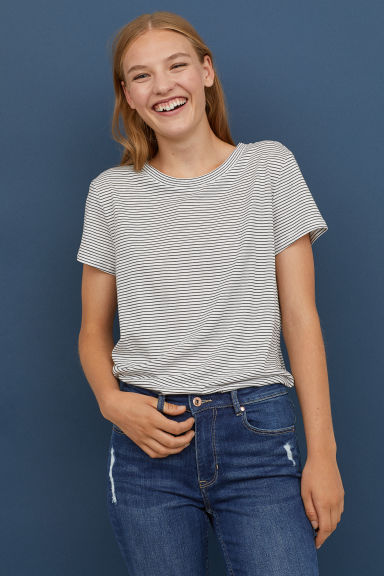

######### 13.jpg ###########


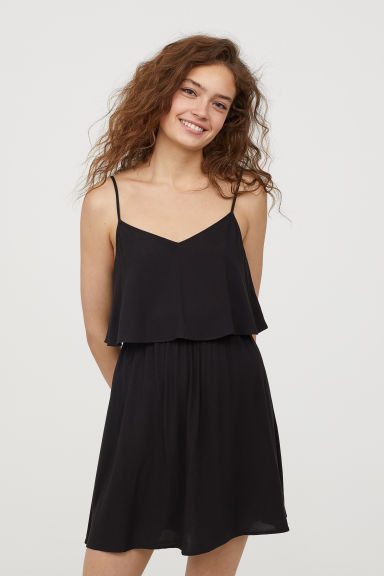

######### 785.jpg ###########
##################################################
group number : 5
##################################################


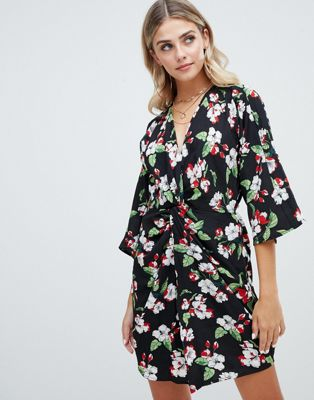

######### 8626.jpg ###########


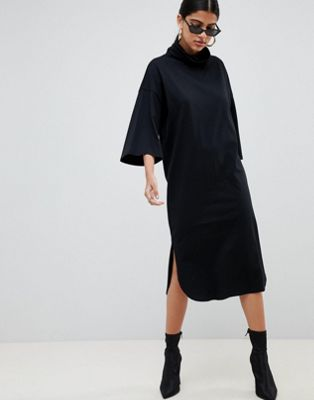

######### 8720.jpg ###########


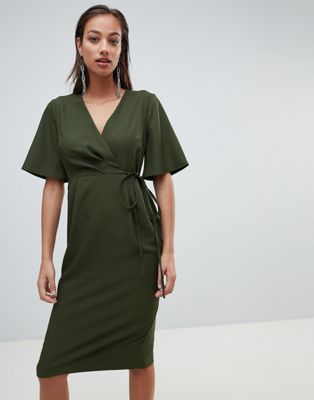

######### 7777.jpg ###########


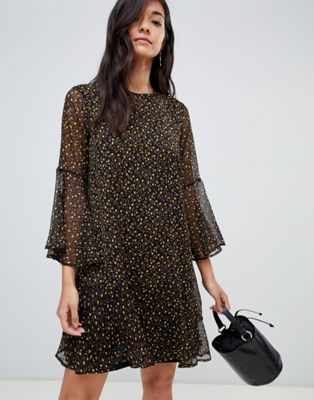

######### 10190.jpg ###########


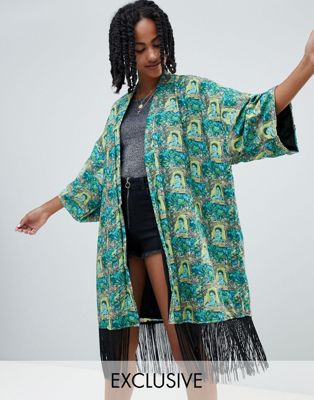

######### 4485.jpg ###########


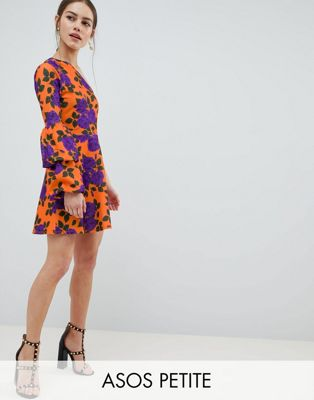

######### 8558.jpg ###########


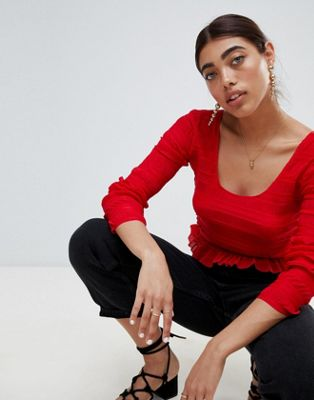

######### 4227.jpg ###########


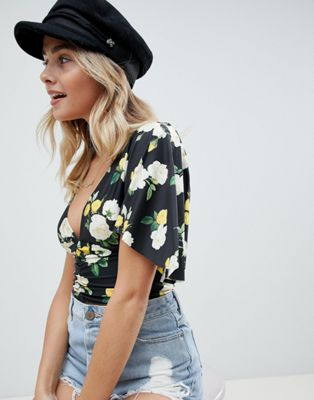

######### 5414.jpg ###########
##################################################
group number : 4
##################################################


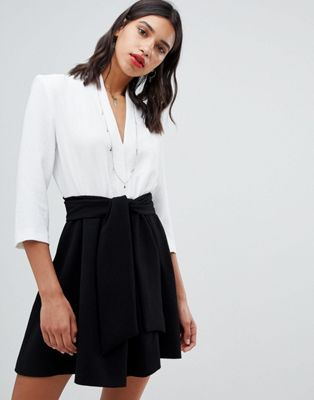

######### 9906.jpg ###########


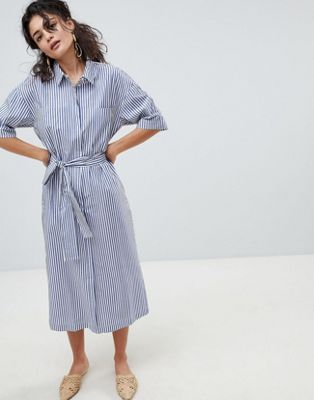

######### 7434.jpg ###########


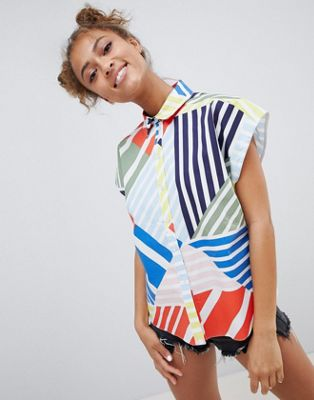

######### 5011.jpg ###########


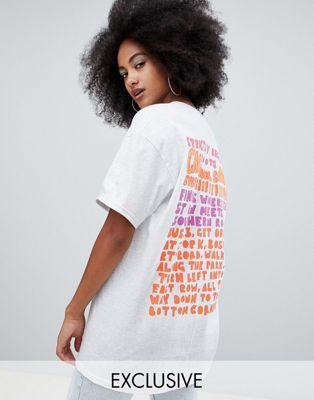

######### 4051.jpg ###########


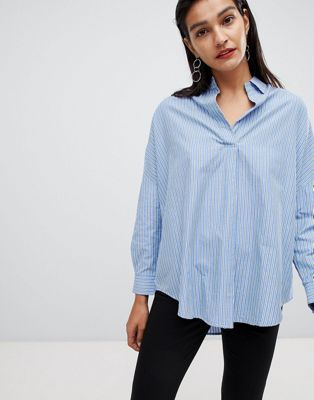

######### 4014.jpg ###########


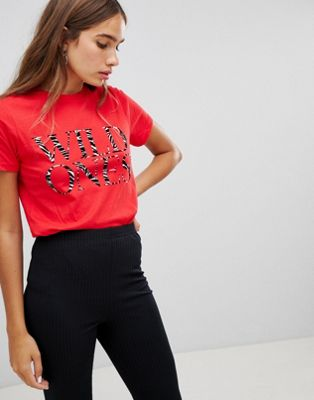

######### 4924.jpg ###########


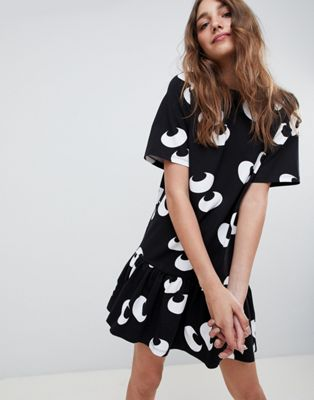

######### 8924.jpg ###########


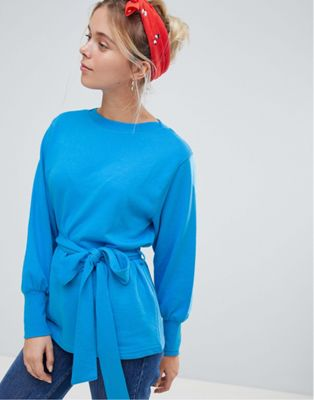

######### 5583.jpg ###########


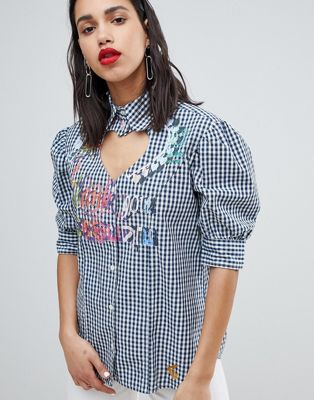

######### 6031.jpg ###########


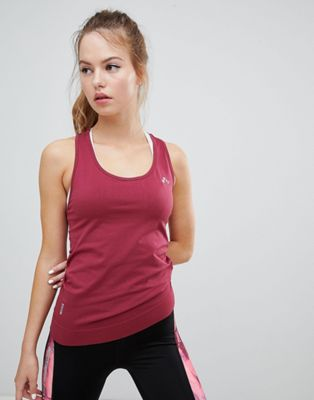

######### 6663.jpg ###########


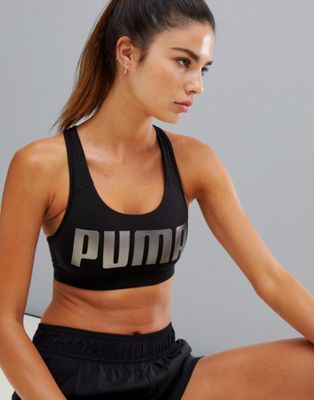

######### 3906.jpg ###########


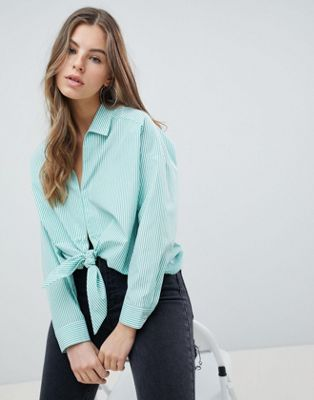

######### 5957.jpg ###########


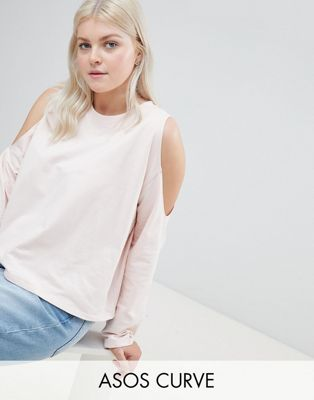

######### 3995.jpg ###########


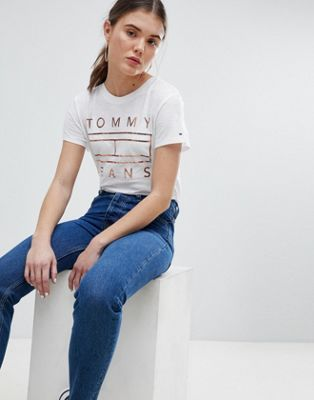

######### 5071.jpg ###########
##################################################
group number : 2
##################################################


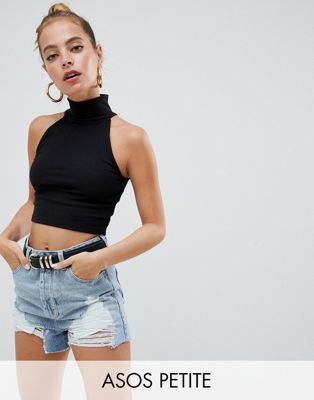

######### 6250.jpg ###########


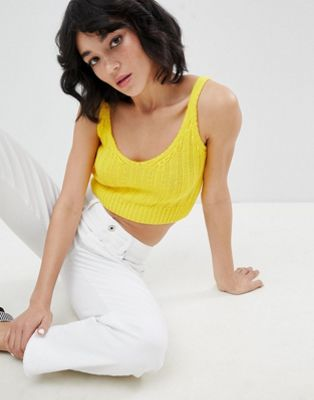

######### 4962.jpg ###########


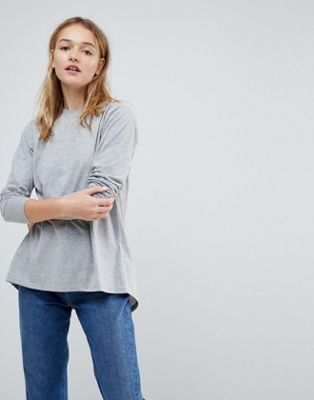

######### 4030.jpg ###########


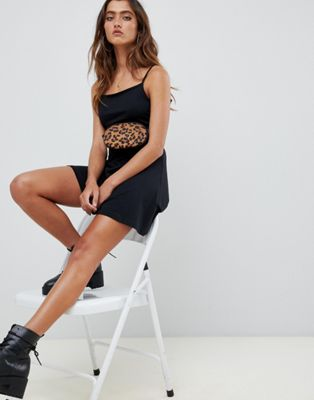

######### 7563.jpg ###########


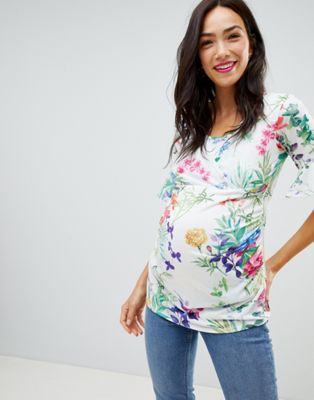

######### 5581.jpg ###########


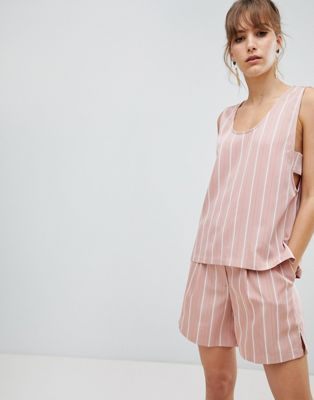

######### 6217.jpg ###########


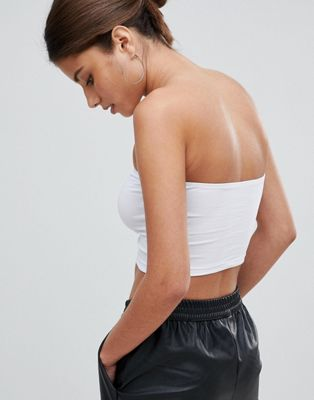

######### 6833.jpg ###########


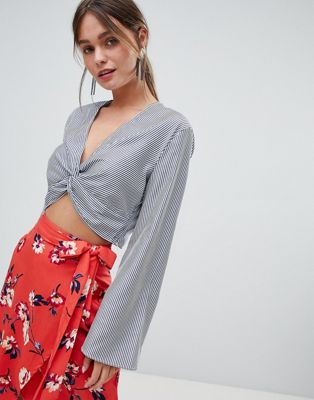

######### 7104.jpg ###########
##################################################
group number : 3
##################################################


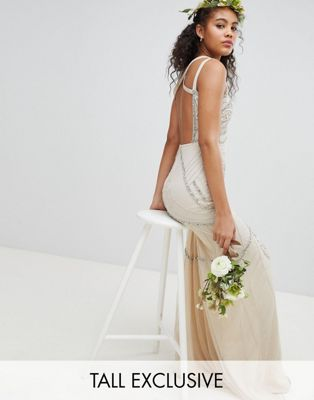

######### 7491.jpg ###########


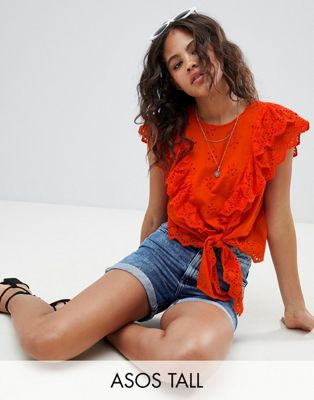

######### 6312.jpg ###########


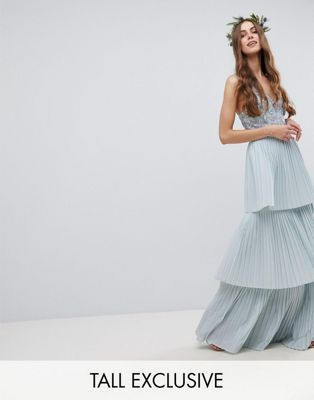

######### 9940.jpg ###########


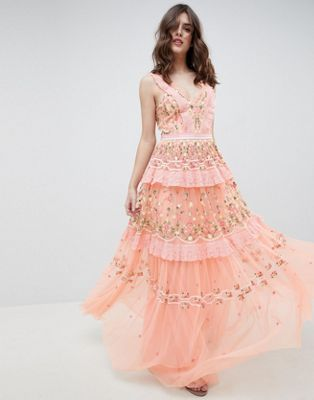

######### 8521.jpg ###########


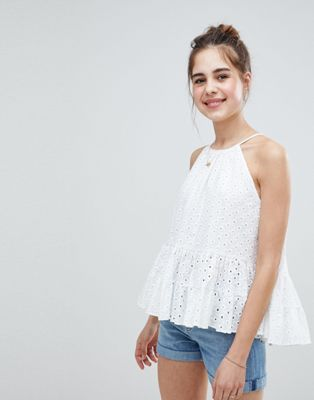

######### 4775.jpg ###########


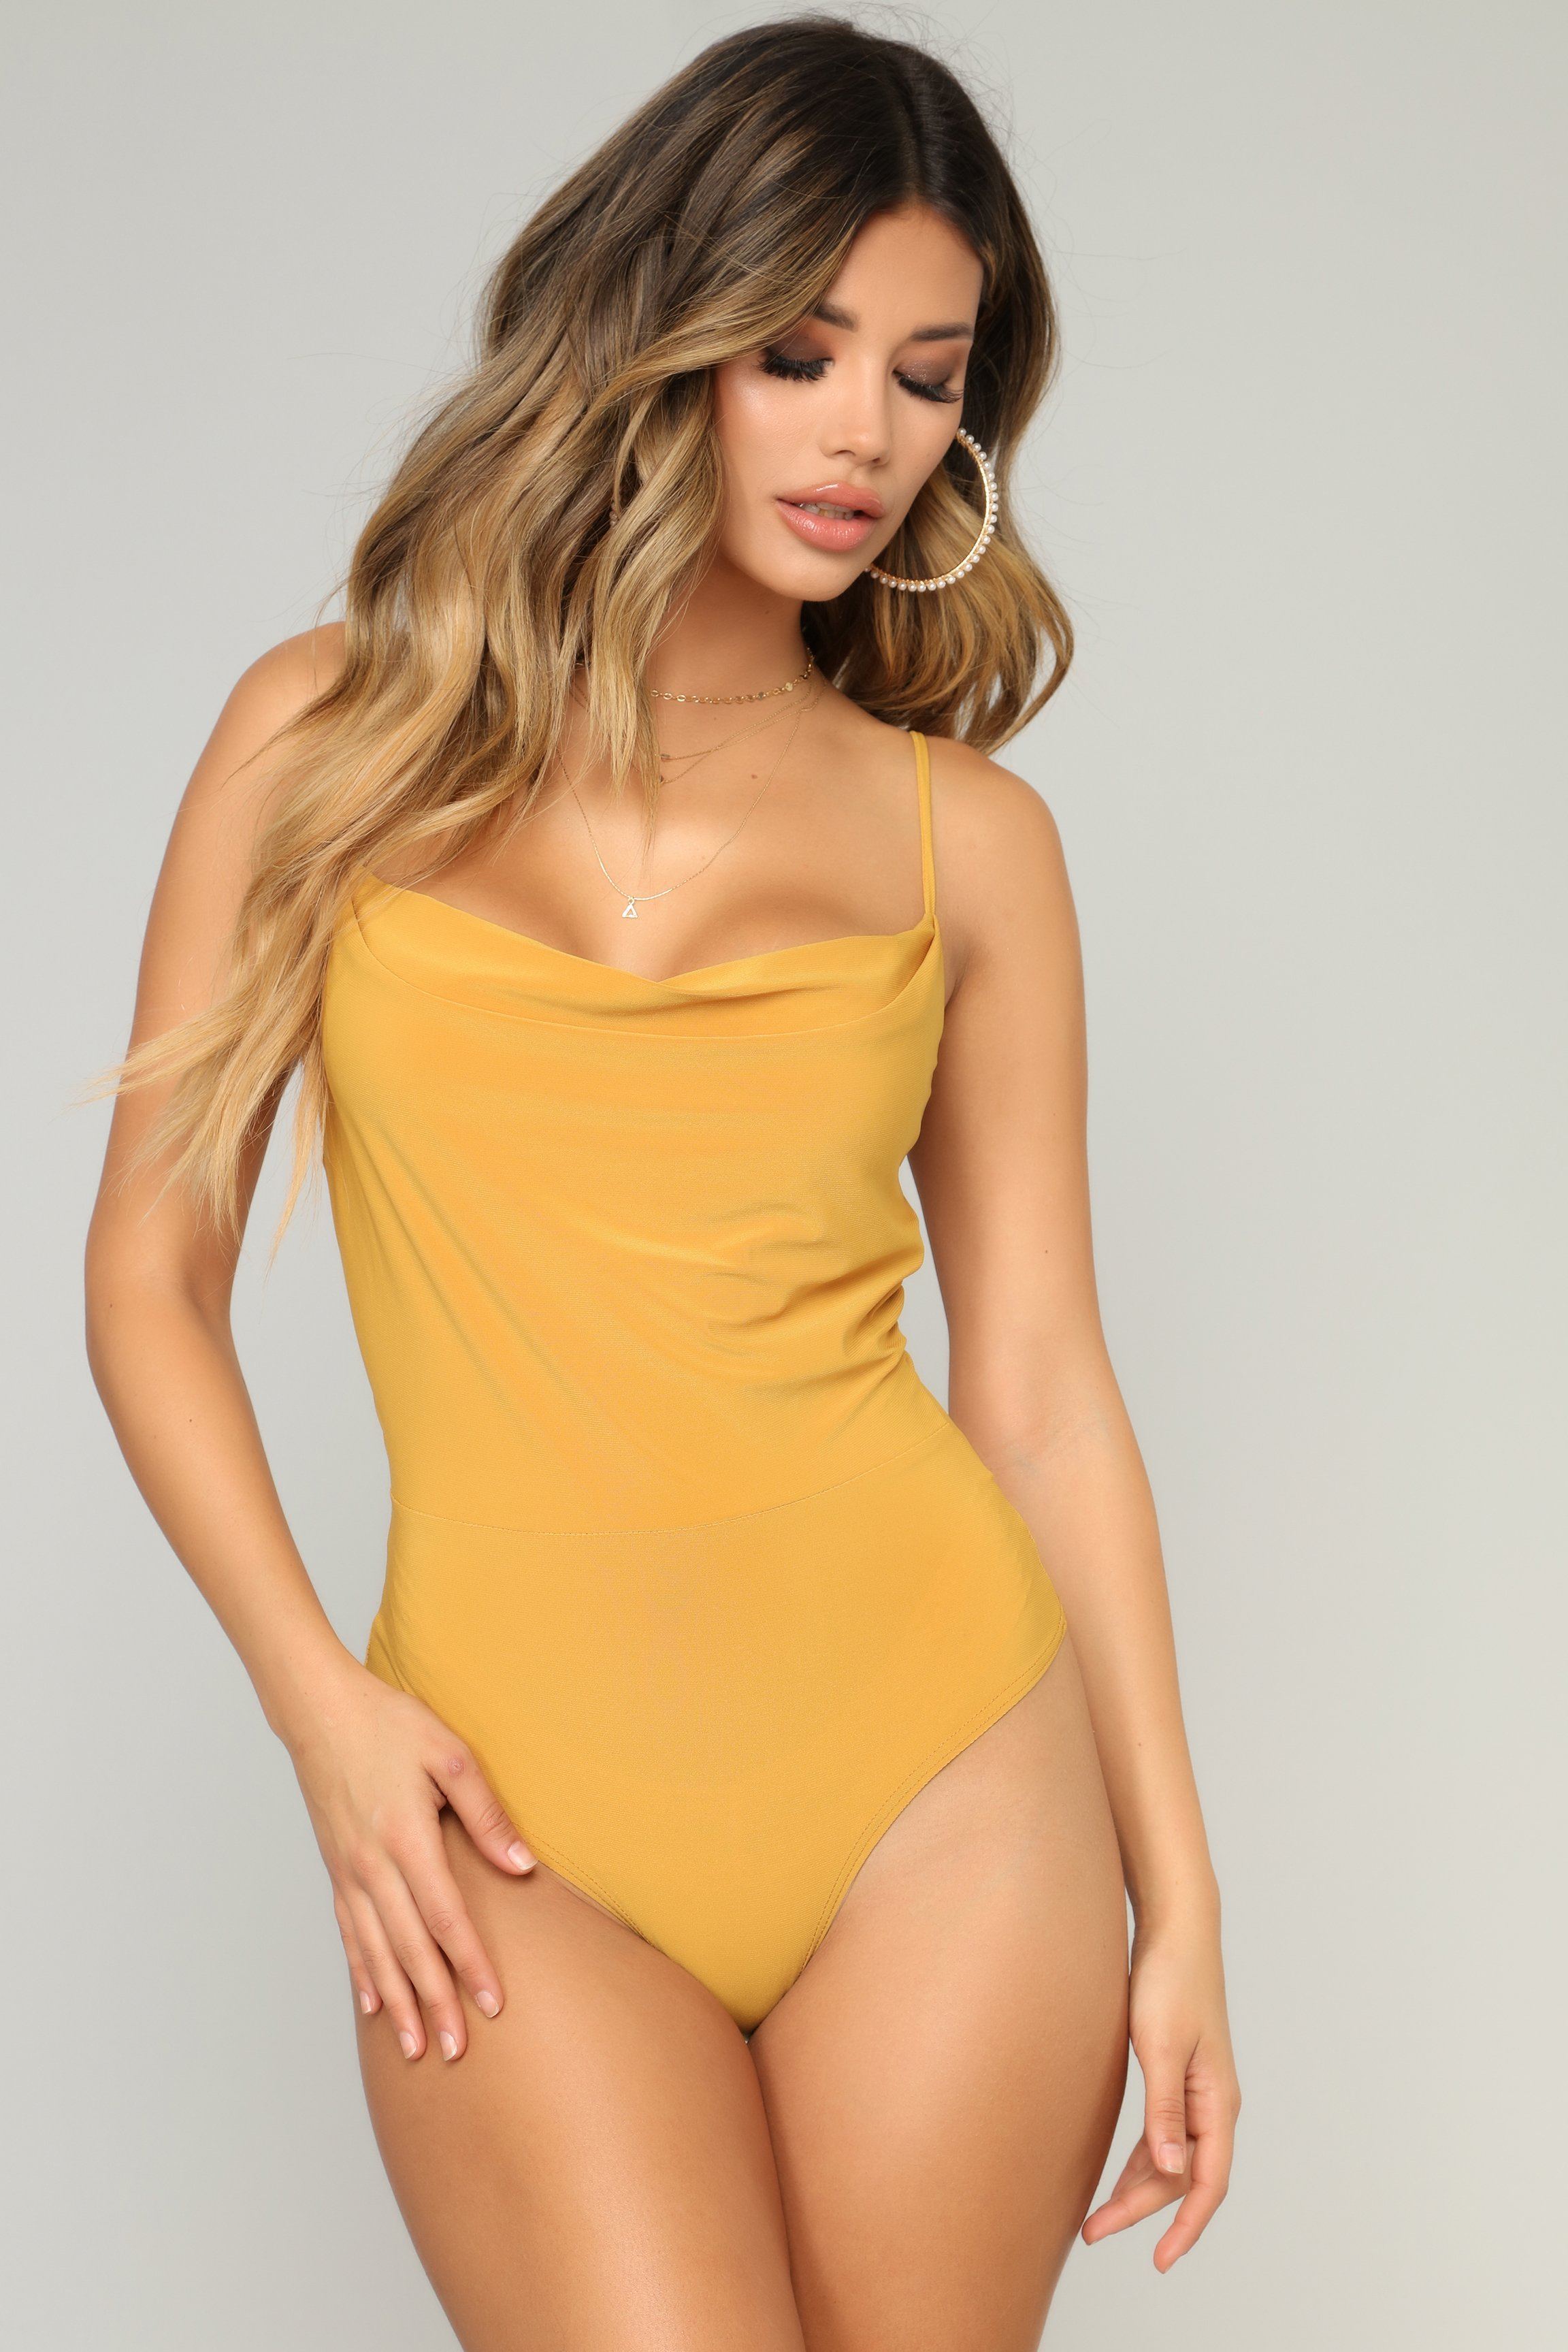

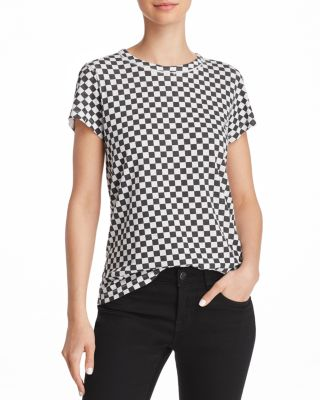

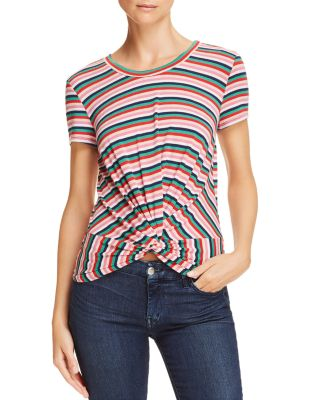

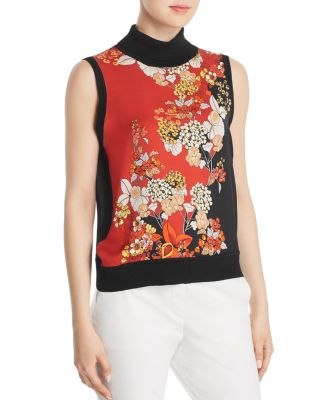

######### 10310.jpg ###########
##################################################
group number : 1
##################################################
######### 2447.jpg ###########
######### 2238.jpg ###########
######### 2540.jpg ###########


In [15]:
groupPic(df_all3.sample(50), lda_md3, dict3_)

In [16]:
# draw the topic graph
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
pyLDAvis.gensim.prepare(lda_md3, corpus3_, dict3_)

PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
5      20.839804        1       1  0.077624 -0.201462
4      19.462589        1       2  0.202365  0.170452
0      17.242712        1       3 -0.215053  0.121097
1      15.753041        1       4 -0.261220  0.097165
2      13.667989        1       5  0.273170  0.051909
3      13.033858        1       6 -0.076887 -0.239161, topic_info=     Category         Freq          Term        Total  loglift  logprob
term                                                                   
5     Default  1628.000000          lace  1628.000000  30.0000  30.0000
165   Default  1167.000000          wrap  1167.000000  29.0000  29.0000
557   Default   935.000000         order   935.000000  28.0000  28.0000
798   Default   826.000000        normal   826.000000  27.0000  27.0000
252   Default   723.000000      washable   723.000000  26.0000  26.0000
100   Default   768.000000         overd   768.000000  25.0000  25.0000
914   Default   628.000000         plain   628.000000  24.0000  24.0000
450   Default   739.000000          logo   739.000000  23.0000  23.0000
842   Default   621.000000          btag   621.000000  22.0000  22.0000
693   Default   597.000000        return   597.000000  21.0000  21.0000
396   Default   749.000000         clean   749.000000  20.0000  20.0000
123   Default   618.000000         shirt   618.000000  19.0000  19.0000
249   Default   631.000000           hit   631.000000  18.0000  18.0000
556   Default   521.000000          item   521.000000  17.0000  17.0000
537   Default   508.000000          base   508.000000  16.0000  16.0000
441   Default   845.000000    silhouette   845.000000  15.0000  15.0000
871   Default   640.000000    complicate   640.000000  14.0000  14.0000
446   Default   797.000000        things   797.000000  13.0000  13.0000
247   Default   511.000000          crea   511.000000  12.0000  12.0000
362   Default   749.000000       comfort   749.000000  11.0000  11.0000
250   Default   500.000000          macy   500.000000  10.0000  10.0000
295   Default   775.000000          wash   775.000000   9.0000   9.0000
472   Default   805.000000         close   805.000000   8.0000   8.0000
293   Default  1082.000000         relax  1082.000000   7.0000   7.0000
433   Default  1165.000000          crop  1165.000000   6.0000   6.0000
587   Default   447.000000     available   447.000000   5.0000   5.0000
680   Default   458.000000          note   458.000000   4.0000   4.0000
147   Default   698.000000        softly   698.000000   3.0000   3.0000
688   Default   455.000000  instructions   455.000000   2.0000   2.0000
691   Default   455.000000       removal   455.000000   1.0000   1.0000
...       ...          ...           ...          ...      ...      ...
229    Topic6   213.744431         tulle   231.254868   1.9589  -4.5177
76     Topic6   197.417358      bodysuit   222.270081   1.9190  -4.5971
789    Topic6   223.923737         fancy   257.471436   1.8980  -4.4711
289    Topic6   245.101288     embellhed   285.702393   1.8843  -4.3808
1052   Topic6    75.234329          iron    80.581047   1.9690  -5.5618
5      Topic6  1128.385498          lace  1628.173462   1.6709  -2.8539
642    Topic6   106.361008          pant   122.025421   1.9002  -5.2156
228    Topic6   216.177124        insert   280.484039   1.7772  -4.5063
156    Topic6   362.262909          mesh   529.900879   1.6573  -3.9901
62     Topic6   205.902435     polyamide   285.685120   1.7101  -4.5550
89     Topic6   352.913666     embroider   584.954712   1.5323  -4.0162
148    Topic6   324.347961          plea   533.363953   1.5402  -4.1006
332    Topic6   124.912621       crochet   157.397095   1.8065  -5.0548
273    Topic6   361.134979         rayon   718.836792   1.3492  -3.9932
715    Topic6   190.816589         fully   306.293427   1.5644  -4.6311
29     Topic6   282.653198         nylon   558.107422   1.3573  -4.23

## LDA with TF-IDF

In [17]:
from gensim import models
import warnings
warnings.filterwarnings('ignore')

In [38]:
dict4_, bow4_ = inputPrep(df_all3, filter_dict = False)

In [39]:
tfidf = models.TfidfModel(bow4_)
tfidf_corpus = tfidf[bow4_]

In [41]:
bow4_[1]

[(1, 2), (8, 1), (9, 1), (10, 2), (11, 2)]

In [42]:
tfidf_corpus[1]

[(1, 0.29423580119996073),
 (8, 0.49936135517455293),
 (9, 0.6075045799672629),
 (10, 0.380090263696474),
 (11, 0.38798596239090355)]

In [44]:
%%time
lda_model_tfidf = gensim.models.LdaMulticore(tfidf_corpus, id2word=dict4_, num_topics = 6, alpha = 0.1, passes=100, iterations=500)
lda_model_tfidf.save('lda_tfidf.model')

CPU times: user 3min 27s, sys: 8.76 s, total: 3min 36s
Wall time: 3min 37s


(3, 0.73885)
(3, 0.70098853)
(4, 0.3670766)
(3, 0.68963075)
(3, 0.68514806)
(3, 0.87937987)
(3, 0.8511685)
(3, 0.76576823)
(4, 0.9418395)
(3, 0.83619106)
(4, 0.9528238)
(3, 0.52984244)
(4, 0.5074466)
(3, 0.594145)
(3, 0.908122)
(3, 0.8328366)
(4, 0.5304908)
(3, 0.7694524)
(4, 0.5911972)
(4, 0.4984465)
(5, 0.586182)
(3, 0.5798491)
(3, 0.5748949)
(3, 0.43498147)
(0, 0.3589408)
(3, 0.61243707)
(3, 0.5975839)
(3, 0.7123308)
(3, 0.9528276)
(3, 0.7398038)
(3, 0.6208598)
(4, 0.56690335)
(3, 0.6061716)
(3, 0.8696245)
(4, 0.7323013)
(3, 0.62139577)
(3, 0.9106993)
(3, 0.5042821)
(3, 0.88270843)
(3, 0.44580075)
(3, 0.5413628)
(3, 0.5649184)
(3, 0.41703218)
(3, 0.5714806)
(4, 0.9242417)
(3, 0.80748475)
(3, 0.579071)
(3, 0.5425989)
(4, 0.83640367)
(3, 0.39105818)
The groups are:
{3: [6290, 7658, 3481, 9591, 4152, 8812, 7201, 9378, 10297, 3933, 3698, 5346, 4003, 8594, 8791, 9175, 7663, 3745, 4862, 3682, 1295, 9618, 5561, 9978, 6242, 3847, 2755, 6250, 9817, 1720, 6330, 5036, 3064, 3798, 3957, 2327, 1

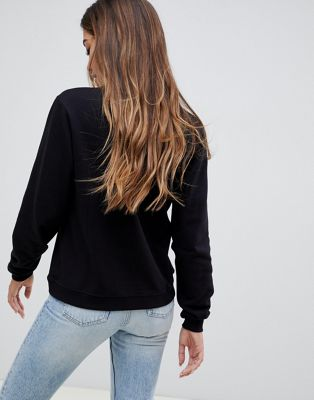

######### 6290.jpg ###########


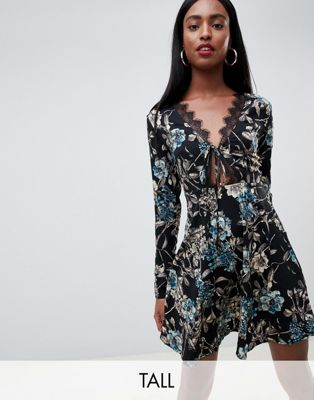

######### 7658.jpg ###########


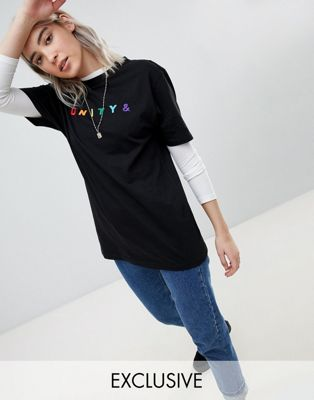

######### 3481.jpg ###########


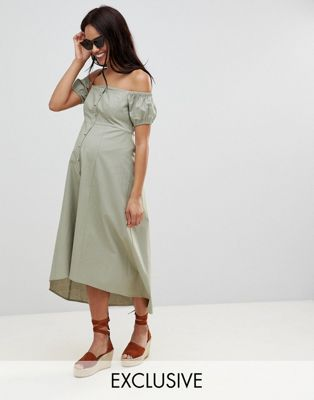

######### 9591.jpg ###########


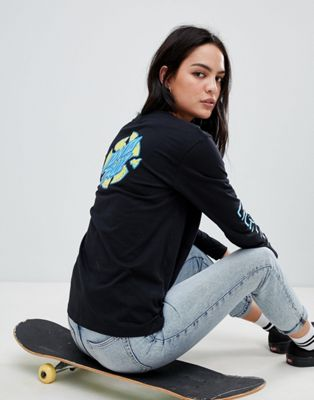

######### 4152.jpg ###########


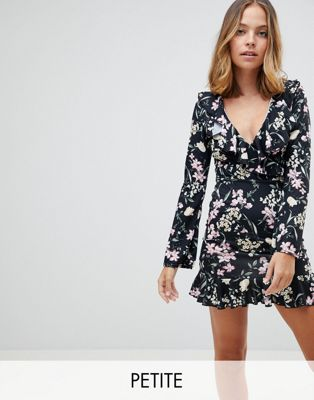

######### 8812.jpg ###########


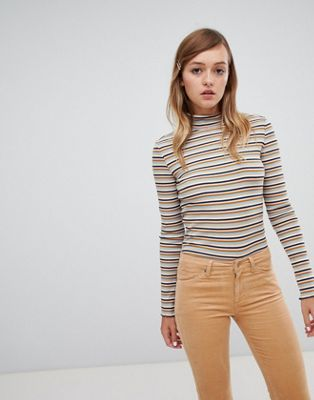

######### 7201.jpg ###########


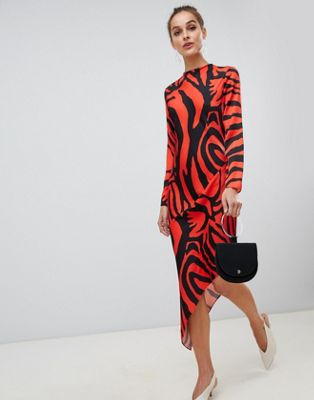

######### 9378.jpg ###########


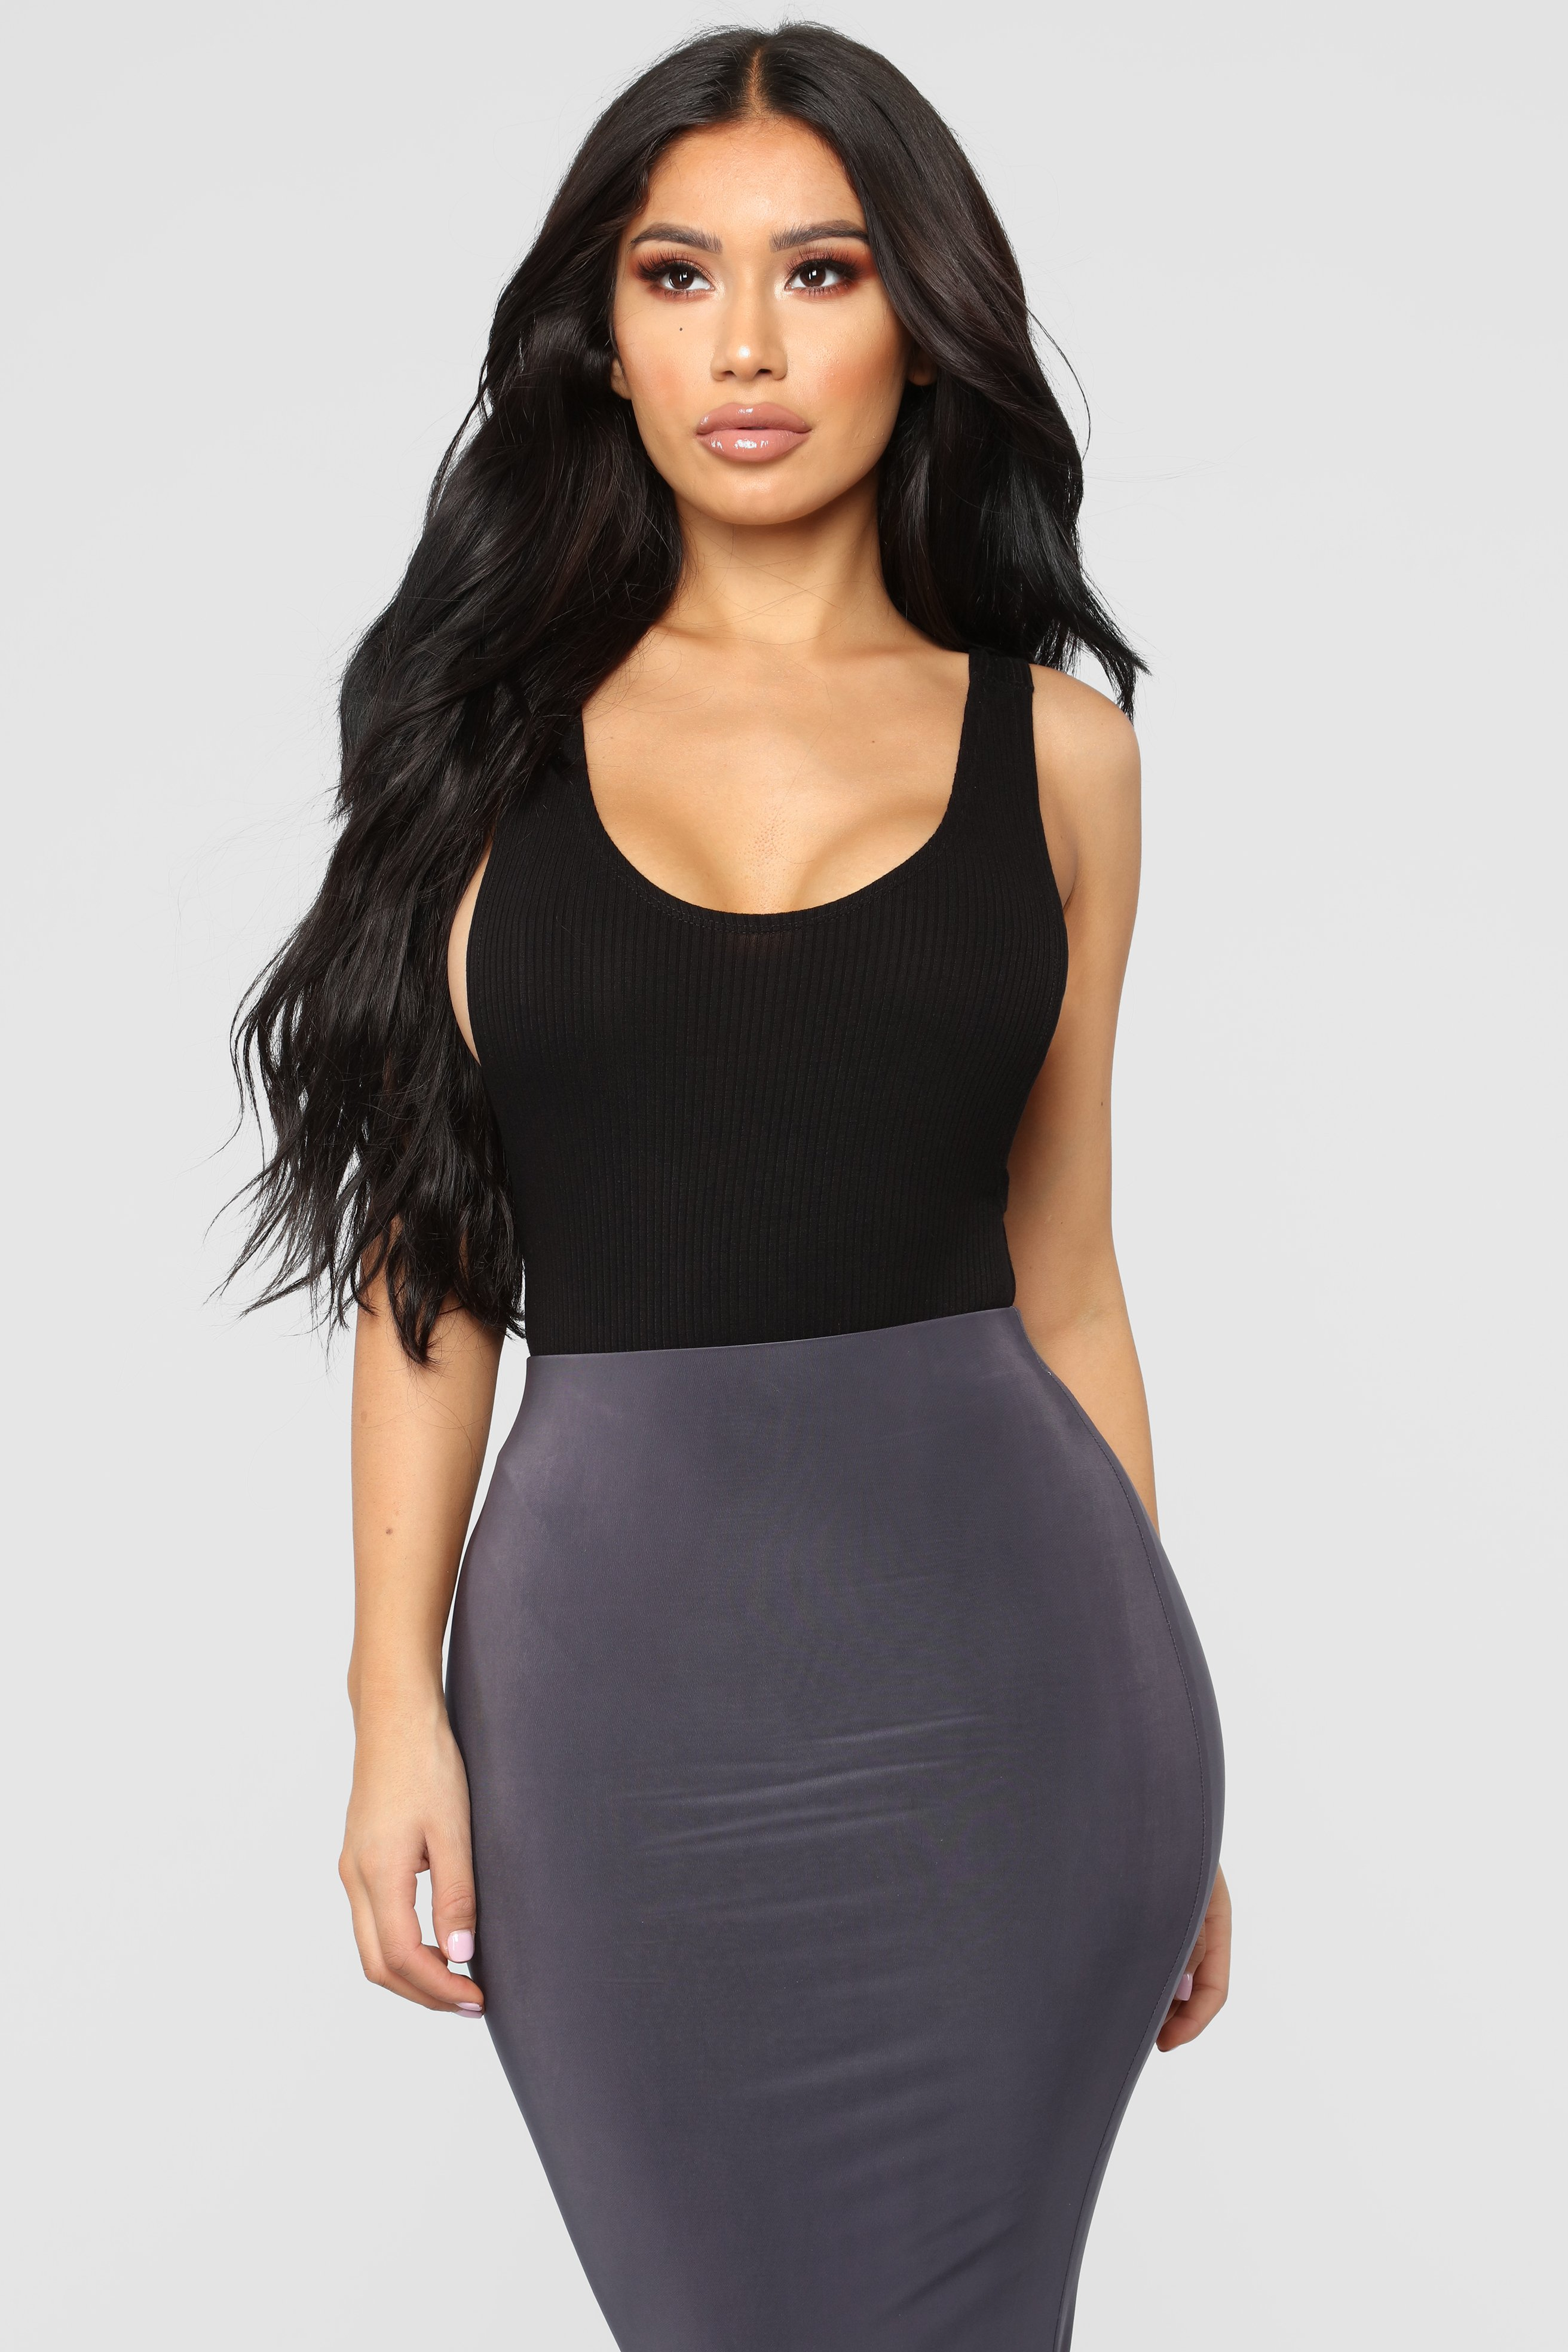

######### 10297.jpg ###########


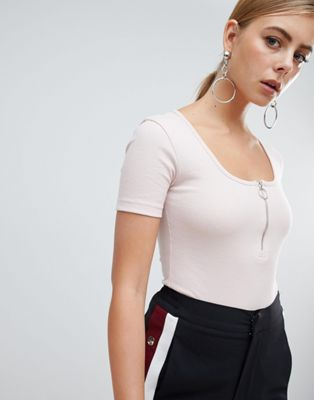

######### 3933.jpg ###########


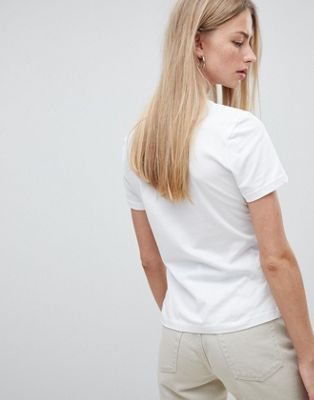

######### 3698.jpg ###########


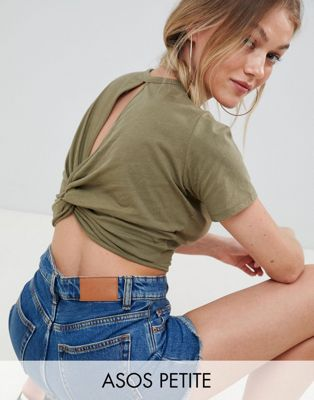

######### 5346.jpg ###########


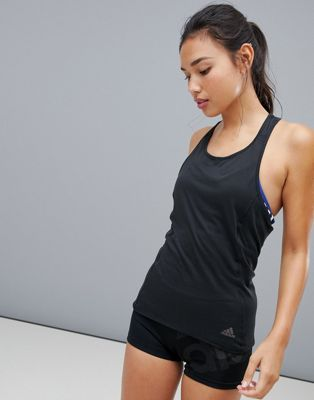

######### 4003.jpg ###########


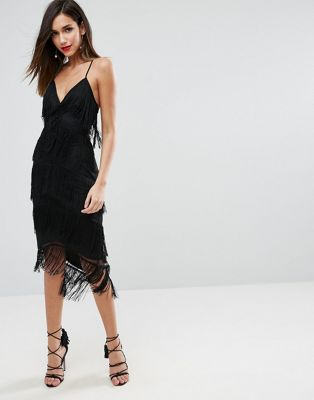

######### 8594.jpg ###########


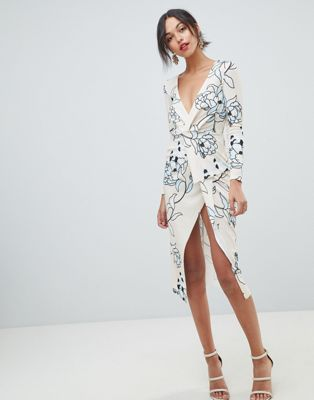

######### 8791.jpg ###########


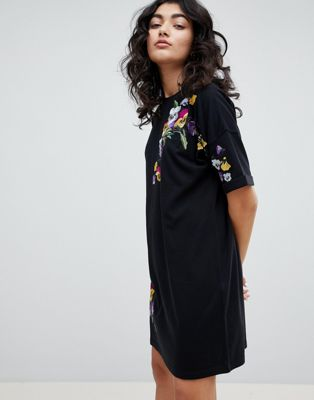

######### 9175.jpg ###########


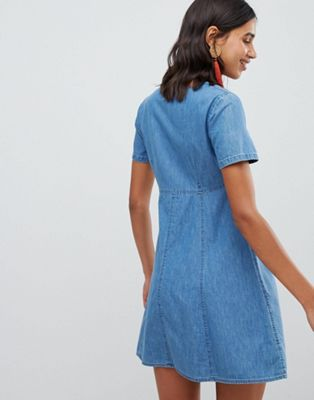

######### 7663.jpg ###########


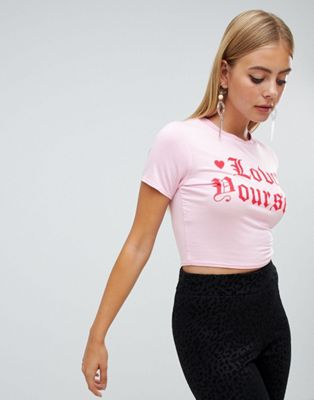

######### 3745.jpg ###########


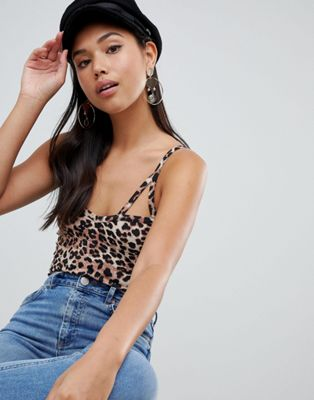

######### 4862.jpg ###########


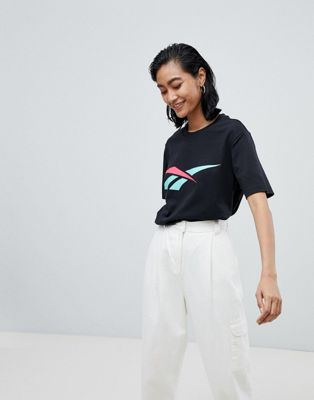

######### 3682.jpg ###########


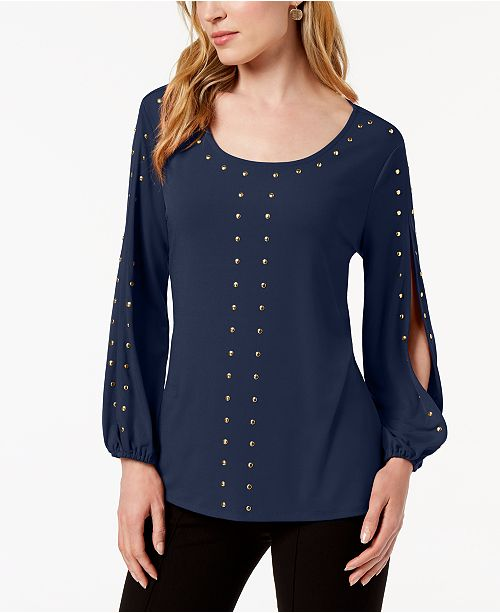

######### 1295.jpg ###########


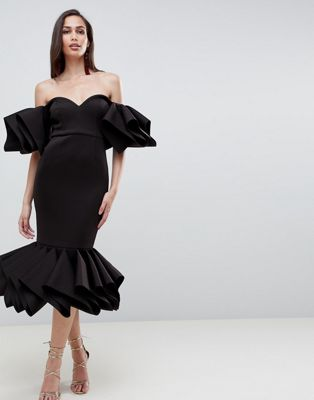

######### 9618.jpg ###########


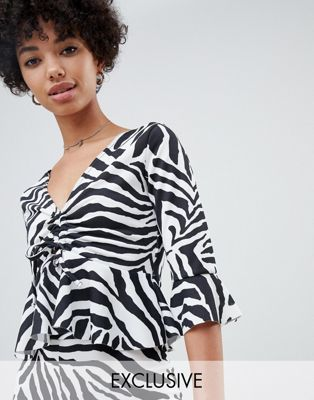

######### 5561.jpg ###########


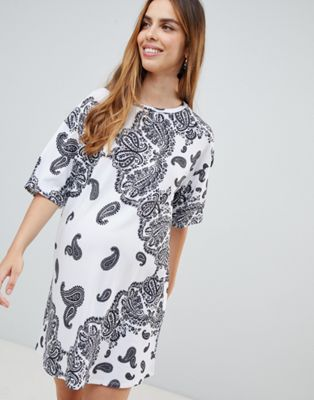

######### 9978.jpg ###########


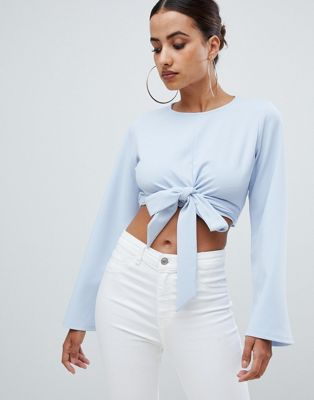

######### 6242.jpg ###########


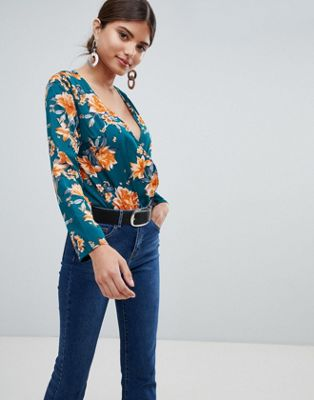

######### 3847.jpg ###########


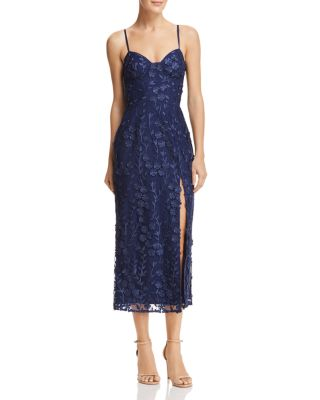

######### 2755.jpg ###########


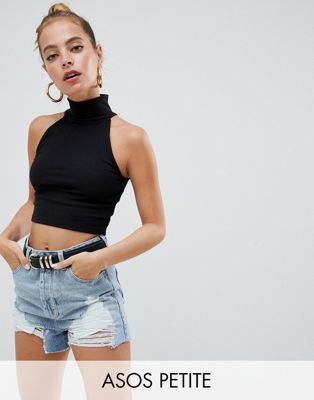

######### 6250.jpg ###########


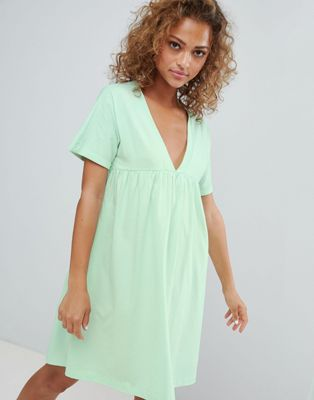

######### 9817.jpg ###########


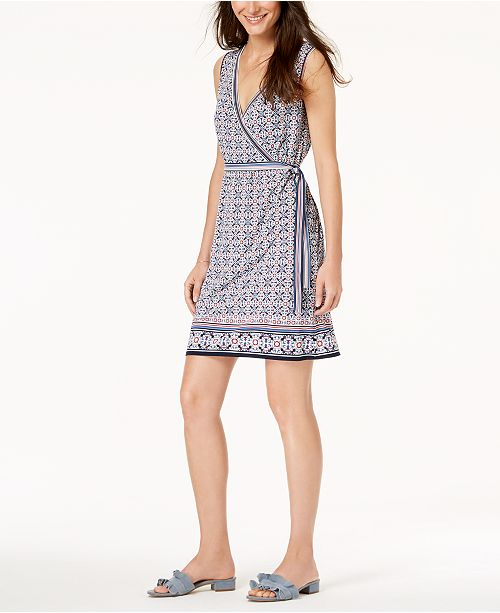

######### 1720.jpg ###########


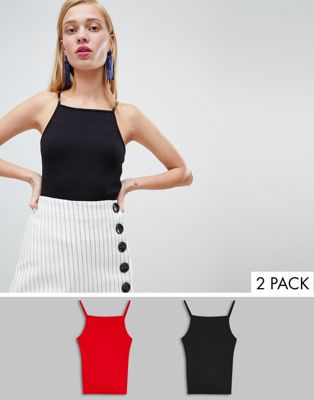

######### 6330.jpg ###########


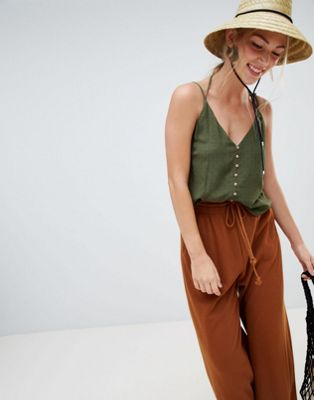

######### 5036.jpg ###########


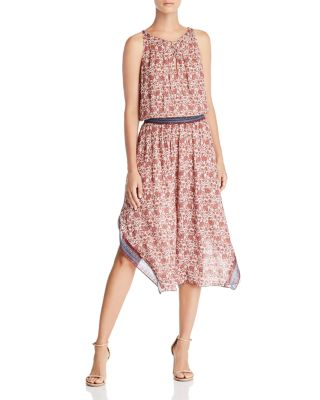

######### 3064.jpg ###########


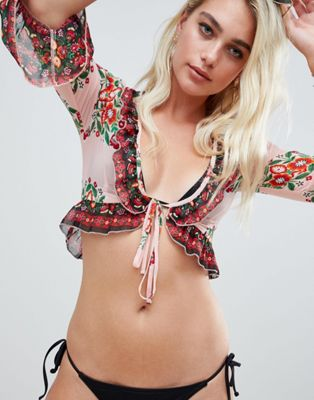

######### 3798.jpg ###########


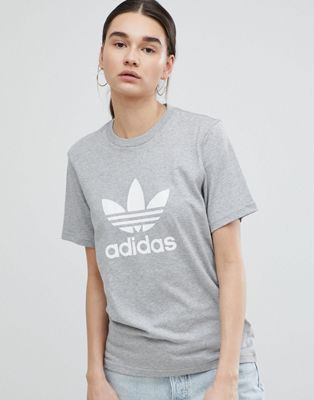

######### 3957.jpg ###########


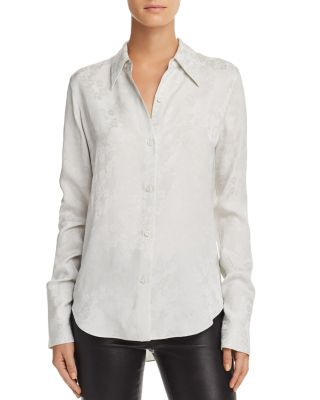

######### 2327.jpg ###########


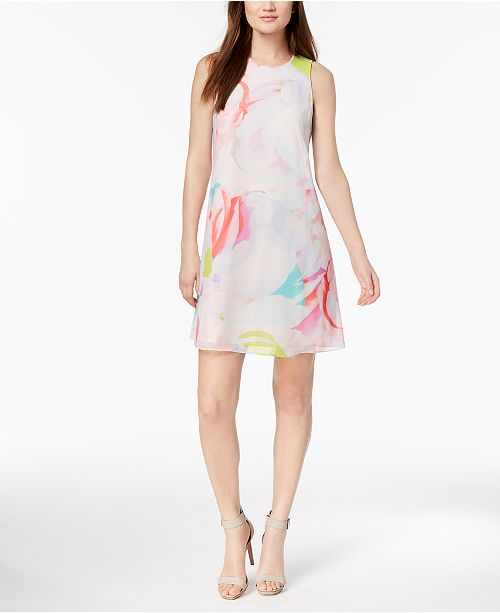

######### 1954.jpg ###########
##################################################
group number : 4
##################################################


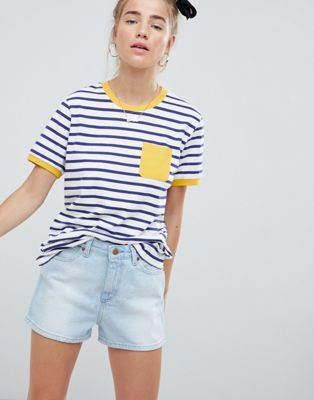

######### 5352.jpg ###########


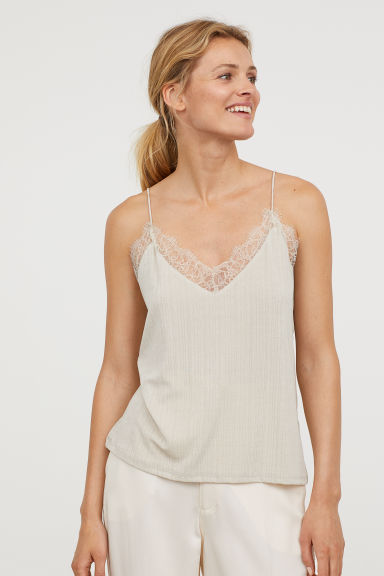

######### 430.jpg ###########


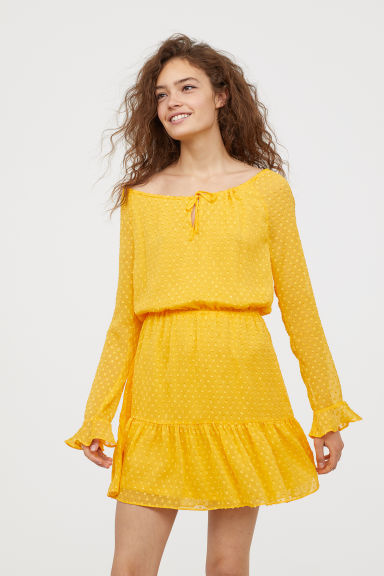

######### 578.jpg ###########


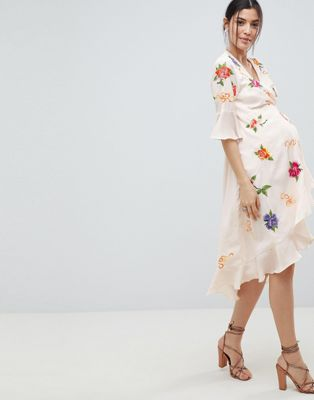

######### 7728.jpg ###########


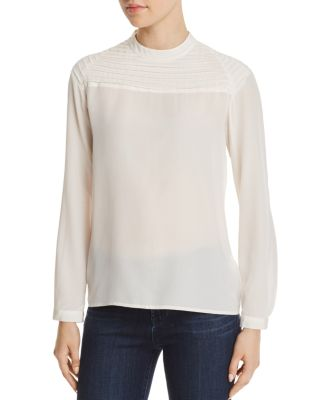

######### 2285.jpg ###########


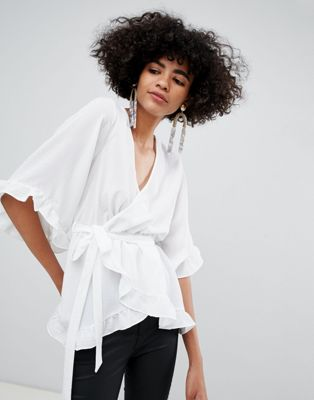

######### 4881.jpg ###########


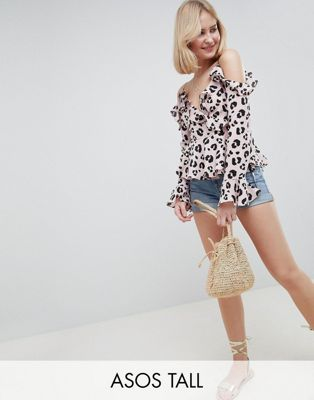

######### 5793.jpg ###########


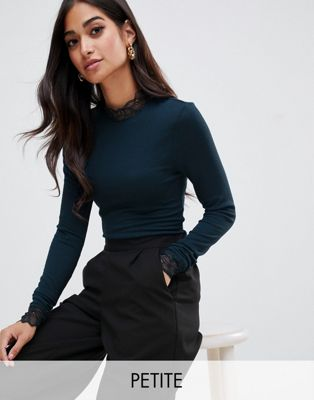

######### 4564.jpg ###########


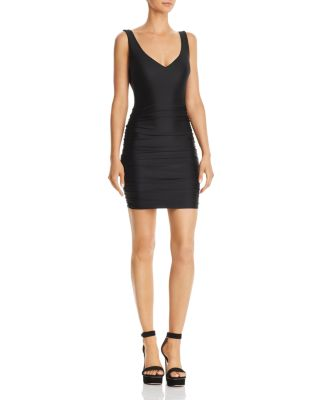

######### 2827.jpg ###########


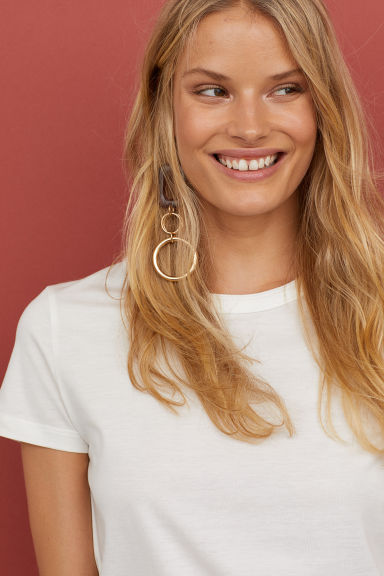

######### 305.jpg ###########


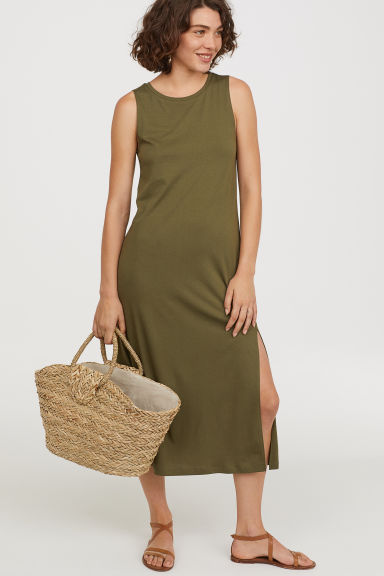

######### 799.jpg ###########
##################################################
group number : 5
##################################################


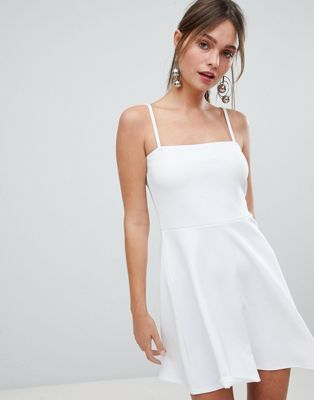

######### 9257.jpg ###########
##################################################
group number : 0
##################################################


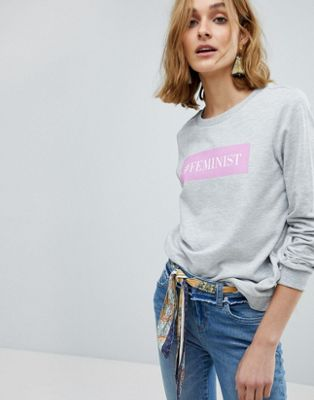

######### 4501.jpg ###########


In [45]:
groupPic(df_all3.sample(50), lda_model_tfidf, dict3_)